In [2]:
import torch
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score
# import torchvision
# import cv2

In [3]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5s')

Using cache found in C:\Users\Saad Mufti/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2022-4-30 torch 1.11.0+cu113 CUDA:0 (NVIDIA GeForce MX130, 2048MiB)

100%|██████████| 14.1M/14.1M [00:16<00:00, 896kB/s] 

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


In [4]:
img = 'raw/CrowdHuman_val/Images/284193,d023000e0070ea1.jpg'
res = model(img)
df_bb = res.pandas().xyxy[0]
df_bb = df_bb[df_bb["class"] == 0]
df_bb["center_x"] = df_bb.apply(lambda r: (r.xmin + r.xmax) / 2, axis=1)
df_bb["center_y"] = df_bb.apply(lambda r: (r.ymin + r.ymax) / 2, axis=1)

centers = df_bb[["center_x", "center_y"]].to_numpy()

print(centers)
res.show()
res.crop(5)
df_bb.head()

[[     378.63      294.01]
 [     592.48      320.49]
 [     478.48      286.74]
 [     301.55       284.5]
 [     166.68      251.06]
 [     71.805      237.31]
 [     378.28      185.58]
 [     580.86      204.34]
 [     235.74      232.65]
 [     432.45      211.93]
 [     521.29      228.87]
 [     540.49      218.75]]


Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



,xmin,ymin,xmax,ymax,confidence,class,name,center_x,center_y
0,331.713531,196.822495,425.547119,391.194336,0.877071,0,person,378.630325,294.008415
1,531.598389,231.740219,653.369446,409.246063,0.845332,0,person,592.483917,320.493141
2,444.806488,183.137665,512.150696,390.351349,0.826170,0,person,478.478592,286.744507
4,255.911804,152.284897,347.191223,416.718201,0.737781,0,person,301.551514,284.501549
5,129.231094,141.720444,204.130859,360.390747,0.726098,0,person,166.680977,251.055595


In [6]:
# Apply clustering algorithm, Approach 1 - Cross Validation

n_p = len(df_bb) # Number of people identified in the frame
k_vars = []

# Find variance of cross-val scores for all k in [1, n_p], and choose the k for which this variance is minimized
for i in range(1, n_p + 1):
    cluster_model = KMeans(n_clusters=i)
    score_var = np.var(cross_val_score(cluster_model, centers, cv=min(5, n_p // 2)))
    k_vars.append(score_var)

k_opt = np.nanargmin(np.array(k_vars))
print(f"Detected {k_opt} clusters")
c_model = KMeans(n_clusters=k_opt).fit(centers)
labels = c_model.predict(centers)

C:\Python39\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
2 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 678, in _fit_and_score
    estimator.fit(X_train, **fit_params)
  File "C:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py", line 1146, in fit
    self._check_params(X)
  File "C:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py", line 947, in _check_params
    raise ValueError(
ValueError: n_samples=9 should be >= n_clusters=10.

  warnings.warn(some_fits_failed_message, FitFailedWarning)
C:\Pytho

Detected 4 clusters


In [58]:
import os
img_cv = cv2.imread(img)
xmin, xmax = df_bb["xmin"].to_numpy(), df_bb["xmax"].to_numpy()
ymin, ymax = df_bb["ymin"].to_numpy(), df_bb["ymax"].to_numpy()
img_crops = [img_cv[int(ymin[i]):int(ymax[i]), int(xmin[i]):int(xmax[i])] for i in range(len(df_bb))]
plt.figure()

if not os.path.exists("./crops"):
    os.mkdir("./crops/")
for loc, r in enumerate(img_crops):
    cv2.imwrite(fr"./crops/{loc}.jpg", r)
# plt.imshow(img_crops[7])

<Figure size 432x288 with 0 Axes>

[0 0 0 1 1 1 0 0 1 0 0 0]


Text(0.5, 1.0, 'Bayesian Clustering Predictions')

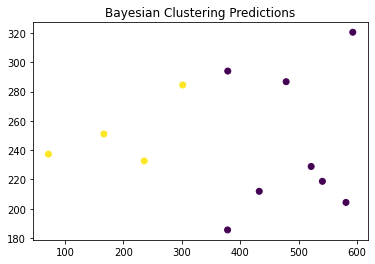

In [44]:
# Apply Clustering algorithm, Approach 2 - Bayesian Clustering (Dirichlet Process)
from sklearn.mixture import BayesianGaussianMixture

bayes_cluster_model = BayesianGaussianMixture(n_components=n_p, n_init=5, max_iter=300, covariance_type="spherical")
bayes_cluster_model.fit(centers)
preds = bayes_cluster_model.predict(centers)
print(preds)

%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(centers.T[0], centers.T[1], c=preds)
ax.set_title("Bayesian Clustering Predictions")
# fig.show()

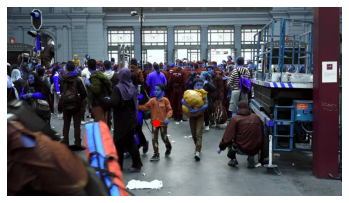

In [21]:
from Body import Body
import openpose_util as util
import copy
import cv2
import matplotlib.pyplot as plt

# pose_model = Body("pt_models/body_pose_model.pth")
%matplotlib inline
plt.imshow(img_cv)
plt.axis("off")
plt.scatter(centers.T[0][0], centers.T[1][0], color="red")
plt.show()